In [3]:
# import from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
import os

# Add the path to your 'src' directory to sys.path
sys.path.append('/content/drive/MyDrive/lab2')

In [5]:
%cd /content/drive/MyDrive/lab2


/content/drive/MyDrive/lab2


In [6]:
ls

1327317/  EDA.ipynb  lab2.ipynb  src/  test.py  train.py


In [7]:
%cd /content/drive/MyDrive/lab2/src/

/content/drive/MyDrive/lab2/src


In [8]:
ls

config.py  dataset.py  model.py  __pycache__/


In [9]:
!python /content/drive/MyDrive/lab2/src/config.py

Starting script
setting finish


In [20]:
%env PYTHONPATH=/content/drive/MyDrive/lab2/
!python /content/drive/MyDrive/lab2/src/dataset.py


env: PYTHONPATH=/content/drive/MyDrive/lab2/
Starting script
setting finish


In [22]:
!pip install segmentation-models-pytorch


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [23]:
!python /content/drive/MyDrive/lab2/src/model.py


Starting script
setting finish


In [24]:
!python /content/drive/MyDrive/lab2/train.py

Starting script
setting finish
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100% 97.8M/97.8M [00:00<00:00, 303MB/s]
/content/drive/MyDrive/lab2/src/dataset.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
Epoch 1/10, Loss: 0.1939
Epoch 2/10, Loss: 0.0847
Epoch 3/10, Loss: 0.0643
Epoch 4/10, Loss: 0.0550
Epoch 5/10, Loss: 0.0493
Epoch 6/10, Loss: 0.0454
Epoch 7/10, Loss: 0.0423
Epoch 8/10, Loss: 0.0399
Epoch 9/10, Loss: 0.0377
Epoch 10/10, Loss: 0.0361


In [25]:
%cd /content/drive/MyDrive/lab2/

/content/drive/MyDrive/lab2


In [29]:
ls

1327317/  deeplabv3.pth  EDA.ipynb  lab2.ipynb  src/  test.py  train.py


📏 Mean Absolute Error on training set: 127.61 mm


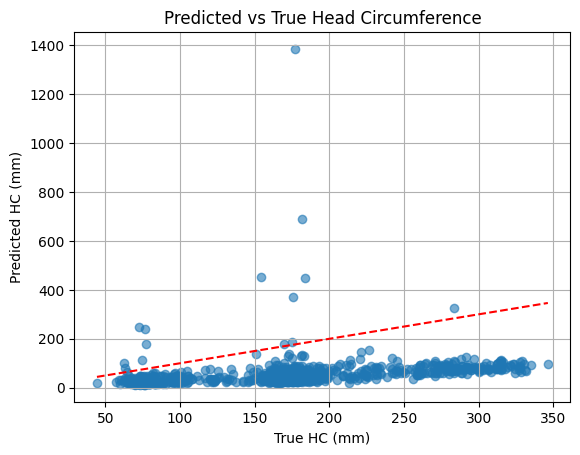

In [34]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp


# === Step 1: Load model and define preprocess ===

model = smp.DeepLabV3(
    encoder_name="resnet50",     # 🔁 Change to "resnet50" if needed
    encoder_weights=None,         # or "imagenet" if you used pretrained encoder
    in_channels=3,
    classes=1
)

model_path = '/content/drive/MyDrive/lab2/deeplabv3.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # or whatever input size your model expects
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("L")
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image_tensor

def get_mask(image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        prob = torch.sigmoid(output)
        mask = (prob > 0.5).squeeze().cpu().numpy().astype(np.uint8)
        return mask

# === Step 2: Extract contours and fit ellipse ===
def compute_hc_from_mask(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    contour = max(contours, key=cv2.contourArea)
    if len(contour) >= 5:
        ellipse = cv2.fitEllipse(contour)
        major, minor = ellipse[1]
        hc_pixels = np.pi * (3*(major + minor) - np.sqrt((3*major + minor)*(major + 3*minor)))
        return hc_pixels
    else:
        return None

# === Step 3: Predict HC for training images and compare ===
train_csv = pd.read_csv("/content/drive/MyDrive/lab2/1327317/training_set_pixel_size_and_HC.csv")
train_image_dir = "/content/drive/MyDrive/lab2/1327317/training_set/"
y_true = []
y_pred = []

for _, row in train_csv.iterrows():
    filename, pixel_size, true_hc = row['filename'], row['pixel size(mm)'], row['head circumference (mm)']
    image_path = os.path.join(train_image_dir, filename)
    image_tensor = preprocess_image(image_path)
    mask = get_mask(image_tensor)
    hc_pixels = compute_hc_from_mask(mask)
    if hc_pixels is not None:
        predicted_hc_mm = hc_pixels * float(pixel_size)
        y_true.append(float(true_hc))
        y_pred.append(predicted_hc_mm)

# === Step 4: Evaluate ===
mae = mean_absolute_error(y_true, y_pred)
print(f"📏 Mean Absolute Error on training set: {mae:.2f} mm")

# Optional: plot predicted vs true HC
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.xlabel('True HC (mm)')
plt.ylabel('Predicted HC (mm)')
plt.title('Predicted vs True Head Circumference')
plt.grid(True)
plt.show()


In [39]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, r2_score
import segmentation_models_pytorch as smp

In [40]:
class MaskHCDataset(Dataset):
    def __init__(self, csv_path, image_dir, seg_model, transform, device):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.seg_model = seg_model
        self.device = device
        self.transform = transform
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row['filename'])

        image = Image.open(image_path).convert("L")
        image_tensor = self.preprocess(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            mask = self.seg_model(image_tensor)
            mask = torch.sigmoid(mask).squeeze().cpu()

        if self.transform:
            mask = self.transform(mask)

        hc = torch.tensor(float(row['head circumference (mm)']), dtype=torch.float32)
        return mask, hc


In [50]:
CSV_PATH = '/content/drive/MyDrive/lab2/1327317/training_set_pixel_size_and_HC.csv'
IMAGE_DIR = '/content/drive/MyDrive/lab2/1327317/training_set/'  # update path if needed
BATCH_SIZE = 8

# ✅ FIXED: Only Normalize, since mask is already a tensor
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# ✅ Also fix in the dataset to add channel dimension before Normalize
class MaskHCDataset(Dataset):
    def __init__(self, csv_path, image_dir, seg_model, transform, device):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.seg_model = model
        self.device = device
        self.transform = transform
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row['filename'])

        image = Image.open(image_path).convert("L")
        image_tensor = self.preprocess(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            mask = self.seg_model(image_tensor)
            mask = torch.sigmoid(mask).squeeze().cpu()  # shape: [H, W]

        if self.transform:
            mask = mask.unsqueeze(0)  # ✅ [1, H, W]
            mask = self.transform(mask)

        hc = torch.tensor(float(row['head circumference (mm)']), dtype=torch.float32)
        return mask, hc

# Create dataset and dataloader
dataset = MaskHCDataset(CSV_PATH, IMAGE_DIR, model, mask_transform, device)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"✅ Loaded {len(dataset)} samples.")


✅ Loaded 999 samples.


In [47]:
class ResNetForRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)

    def forward(self, x):
        return self.model(x)

regressor = ResNetForRegression().to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
NUM_EPOCHS = 20
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(regressor.parameters(), lr=0.001)

for epoch in range(NUM_EPOCHS):
    regressor.train()
    running_loss = 0.0
    for masks, hcs in loader:
        masks, hcs = masks.to(device), hcs.unsqueeze(1).to(device)
        optimizer.zero_grad()
        preds = regressor(masks)
        loss = criterion(preds, hcs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {running_loss/len(loader):.4f}")


Epoch 1/20 - Loss: 21456.9694
Epoch 2/20 - Loss: 5122.9370
Epoch 3/20 - Loss: 2850.5272
Epoch 4/20 - Loss: 2449.3538
Epoch 5/20 - Loss: 2169.8517
Epoch 6/20 - Loss: 1897.3398
Epoch 7/20 - Loss: 1911.1792
Epoch 8/20 - Loss: 1726.3580
Epoch 9/20 - Loss: 1597.9308
Epoch 10/20 - Loss: 1583.3034
Epoch 11/20 - Loss: 1381.5064
Epoch 12/20 - Loss: 1297.0688
Epoch 13/20 - Loss: 1199.9169
Epoch 14/20 - Loss: 1184.2683
Epoch 15/20 - Loss: 1148.3235
Epoch 16/20 - Loss: 935.6489
Epoch 17/20 - Loss: 849.2312
Epoch 18/20 - Loss: 872.0445
Epoch 19/20 - Loss: 782.1888
Epoch 20/20 - Loss: 672.2352


In [52]:
torch.save(regressor.state_dict(), '/content/drive/MyDrive/lab2/hc_from_mask.pth')
print("✅ Model saved to 'hc_from_mask.pth'")


✅ Model saved to 'hc_from_mask.pth'


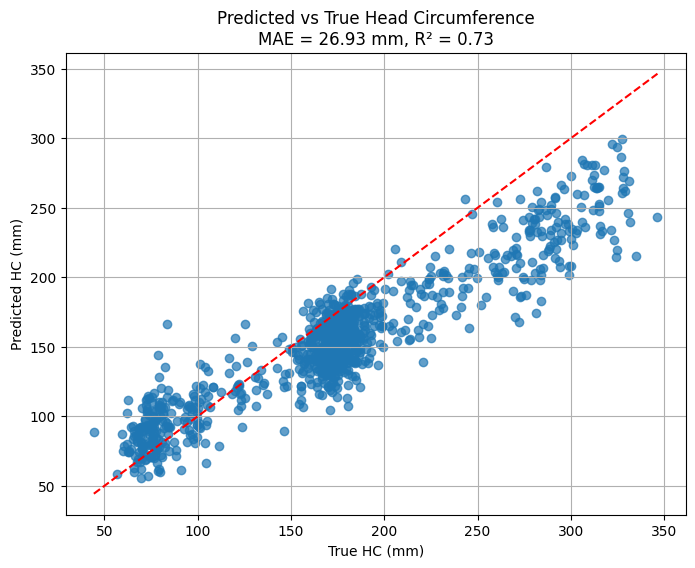

In [54]:
regressor.eval()
true_hcs, predicted_hcs = [], []

with torch.no_grad():
    for masks, hcs in loader:
        masks = masks.to(device)
        preds = regressor(masks).squeeze(1)
        true_hcs.extend(hcs.numpy())
        predicted_hcs.extend(preds.cpu().numpy())

# Plot
mae = mean_absolute_error(true_hcs, predicted_hcs)
r2 = r2_score(true_hcs, predicted_hcs)

plt.figure(figsize=(8, 6))
plt.scatter(true_hcs, predicted_hcs, alpha=0.7)
plt.plot([min(true_hcs), max(true_hcs)], [min(true_hcs), max(true_hcs)], 'r--')
plt.xlabel("True HC (mm)")
plt.ylabel("Predicted HC (mm)")
plt.title(f"Predicted vs True Head Circumference\nMAE = {mae:.2f} mm, R² = {r2:.2f}")
plt.grid(True)
plt.show()
